 # Numerical Analysis of Cultural Trait Dynamics



 **Problem statement.**

 We consider a finite-population birth–death model of cultural traits with innovation and social learning.

 The state is the popularity distribution $f_k$ over trait counts $k=1\ldots N$, satisfying

 $$

 f = P^T f + b,

 $$

 and the extinction times $\tau$ solving

 $$

 (I - P)\,\tau = \mathbf{1},

 $$

 in persistence mode.



 Closed-form solutions from `analytical.py`:

 - `popularity(N, M, p_d, p_s, ...)`

 - `persistence(N, M, p_d, p_s, ...)`

 ## Model parameters and options

 - **N**: population size (popularity levels)

 - **M**: number of role models

 - **p_d**: innovation rate

 - **p_s**: social learning probability

 - **attempt**: 'union' / 'exposures' / 'budget' / 'public'

 - **sampling**: 'with' / 'without' replacement

 - **pool**: 'infinite' / 'finite'

 - **mode**: 'popularity' / 'persistence'

 - **solver**: 'direct' / 'linear' / 'jacobi' / 'gauss_seidel' / 'nonlinear' / 'newton'

 ## Setup

 Load libraries, parameter grids, and helper functions.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from cultural_evolution.experiments import (
    generate_parameter_grid,
    run_experiments,
    normalize,
    shannon_entropy,
    simpson_index,
)
from cultural_evolution.solvers import solve_model
from cultural_evolution.analytical import popularity, persistence
from cultural_evolution.system import get_transition_matrix



 ## 1. Baseline Model Sweeps

 Sweep over basic parameter ranges using the direct solver and compare to closed-form.

In [137]:
# Define parameter grid for baseline
baseline_params = {
    "N": [100],
    "M": [1, 2, 3, 4, 5],
    "p_d": [0.1],
    "p_s": [0.1, 0.3, 0.5, 0.7, 0.9],
}
param_grid = generate_parameter_grid(baseline_params)

solver_configs = [
    {"mode": "popularity", "solver": "direct", "trace": False},
    {"mode": "persistence", "solver": "direct", "trace": False},
]

# Run experiments
baseline_summary, baseline_solutions = run_experiments(
    param_grid, solver_configs, parallel=False
)

# Display head of results
baseline_summary.head()


,N,M,p_d,p_s,mode,solver,time,iterations,error_L2,error_inf
0,100,1,0.1,0.1,popularity,direct,0.004795,1,1.243897e-14,1.243450e-14
1,100,1,0.1,0.1,persistence,direct,0.004748,1,3.411233e+03,4.277339e+02
2,100,1,0.1,0.3,popularity,direct,0.004590,1,1.617047e-14,1.598721e-14
3,100,1,0.1,0.3,persistence,direct,0.004564,1,3.533775e+03,4.516625e+02
4,100,1,0.1,0.5,popularity,direct,0.004813,1,4.340294e-14,4.085621e-14


 ### Comparison Analytical vs Direct Solver

 #### Popularity Distributions by M (Analytical vs Direct Solver)

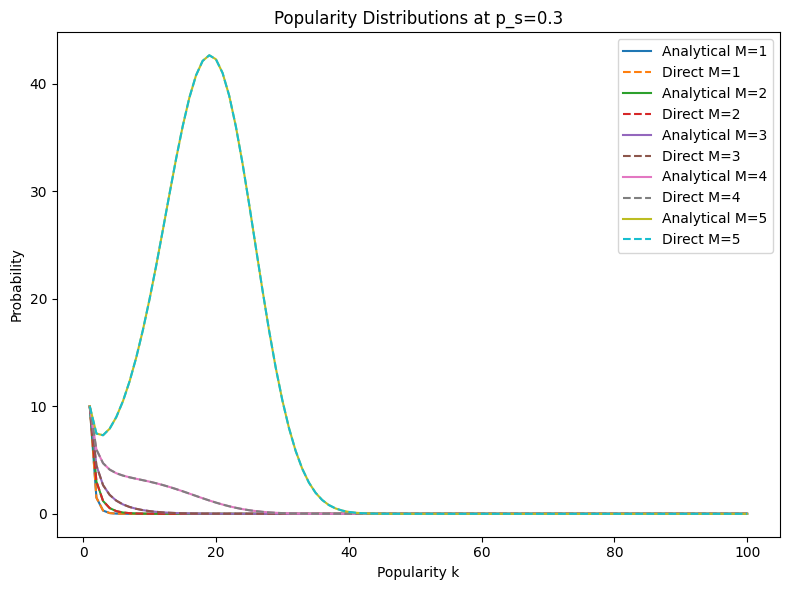

In [138]:
plt.figure(figsize=(8, 6))
p_s_val = 0.3
for M_val in baseline_params["M"]:
    params = {
        "N": baseline_params["N"][0],
        "M": M_val,
        "p_d": baseline_params["p_d"][0],
        "p_s": p_s_val,
    }
    # analytical
    f_true = popularity(**params)
    plt.plot(np.arange(1, params["N"] + 1), f_true, label=f"Analytical M={M_val}")
    # direct solver
    sol_vec = baseline_solutions[
        (baseline_solutions["mode"] == "popularity")
        & (baseline_solutions["solver"] == "direct")
        & (baseline_solutions["M"] == M_val)
        & (baseline_solutions["p_s"] == p_s_val)
    ]["solution"].values[0]
    plt.plot(np.arange(1, params["N"] + 1), sol_vec, "--", label=f"Direct M={M_val}")
plt.title(f"Popularity Distributions at p_s={p_s_val}")
plt.xlabel("Popularity k")
plt.ylabel("Probability")
plt.legend()
plt.tight_layout()


 #### Persistence Distributions by M (Analytical vs Direct Solver)

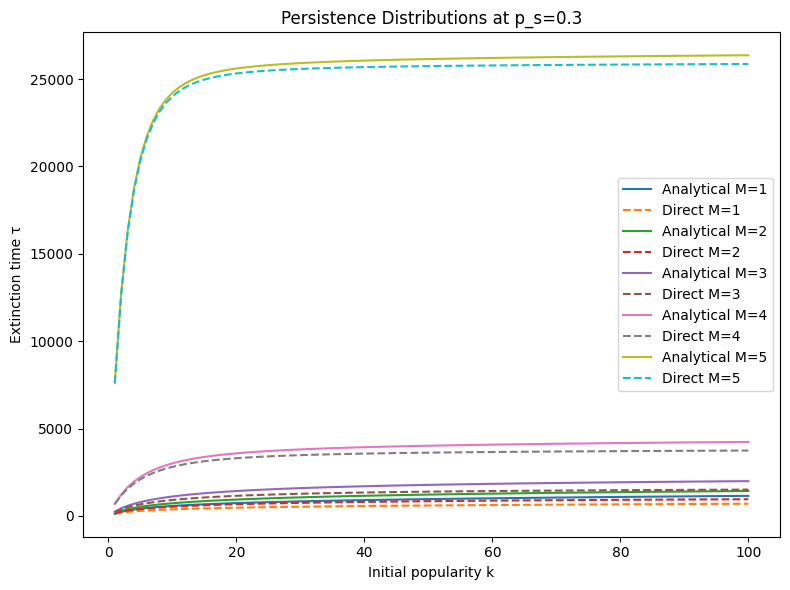

In [139]:
plt.figure(figsize=(8, 6))
p_s_val = 0.3
for M_val in baseline_params["M"]:
    params = {
        "N": baseline_params["N"][0],
        "M": M_val,
        "p_d": baseline_params["p_d"][0],
        "p_s": p_s_val,
    }
    # analytical persistence
    tau_true = persistence(**params)
    plt.plot(np.arange(1, params["N"] + 1), tau_true, label=f"Analytical M={M_val}")
    # direct solver persistence
    sol_tau = baseline_solutions[
        (baseline_solutions["mode"] == "persistence")
        & (baseline_solutions["solver"] == "direct")
        & (baseline_solutions["M"] == M_val)
        & (baseline_solutions["p_s"] == p_s_val)
    ]["solution"].values[0]
    plt.plot(np.arange(1, params["N"] + 1), sol_tau, "--", label=f"Direct M={M_val}")
plt.title(f"Persistence Distributions at p_s={p_s_val}")
plt.xlabel("Initial popularity k")
plt.ylabel("Extinction time τ")
plt.legend()
plt.tight_layout()



 ### Total Traits vs $p_s$ for Different $M$ (Log Scale)

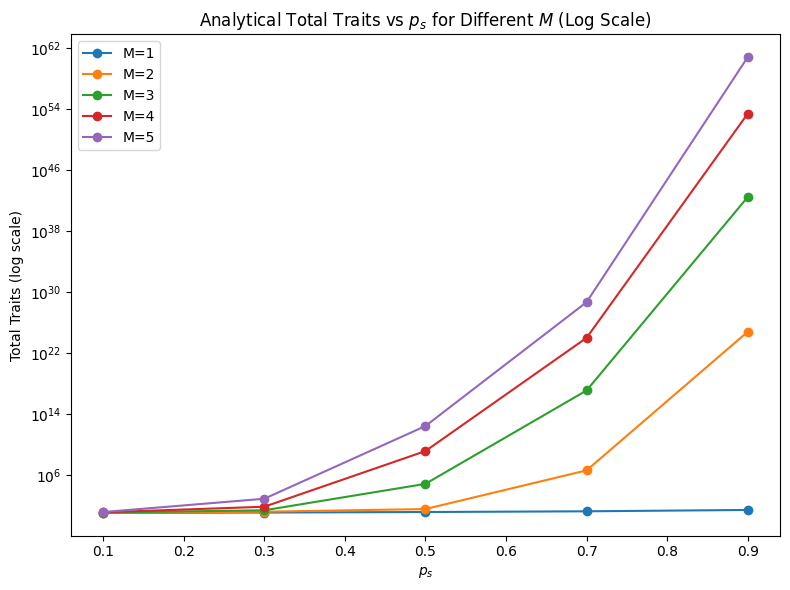

In [140]:
plt.figure(figsize=(8, 6))
N_val = baseline_params["N"][0]
p_d_val = baseline_params["p_d"][0]
for M_val in baseline_params["M"]:
    xs = baseline_params["p_s"]
    ys = [np.sum(popularity(N=N_val, M=M_val, p_d=p_d_val, p_s=ps)) for ps in xs]
    plt.plot(xs, ys, marker="o", label=f"M={M_val}")
plt.yscale("log")
plt.title(r"Analytical Total Traits vs $p_s$ for Different $M$ (Log Scale)")
plt.xlabel(r"$p_s$")
plt.ylabel("Total Traits (log scale)")
plt.legend()
plt.tight_layout()


 ### Time vs Error Scatter (Baseline & Direct Solver, Log-Log)

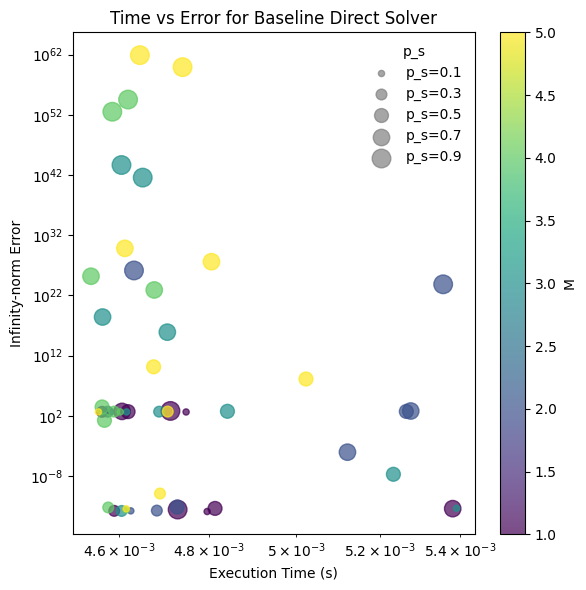

In [141]:
subset = baseline_summary[baseline_summary["solver"] == "direct"]
plt.figure(figsize=(6, 6))
sizes = subset["p_s"] * 200
scatter = plt.scatter(
    subset["time"],
    subset["error_inf"],
    c=subset["M"],
    s=sizes,
    cmap="viridis",
    alpha=0.7,
)
plt.xscale("log")
plt.yscale("log")
cbar = plt.colorbar(scatter)
cbar.set_label("M")
for p_s_val in sorted(subset["p_s"].unique()):
    plt.scatter([], [], c="gray", alpha=0.7, s=p_s_val * 200, label=f"p_s={p_s_val}")
plt.legend(scatterpoints=1, frameon=False, title="p_s")
plt.xlabel("Execution Time (s)")
plt.ylabel("Infinity-norm Error")
plt.title("Time vs Error for Baseline Direct Solver")
plt.tight_layout()


 ## 2. Solver Performance Comparison

 Compare iteration counts and timing across different solvers for a fixed parameter set.

In [142]:
# Single parameter set for solver comparison
single_params = {"N": 100, "M": 5, "p_d": 0.1, "p_s": 0.3}

solver_list = ["direct", "linear", "jacobi", "gauss_seidel"]
solver_configs = [
    {"mode": "popularity", "solver": sol, "trace": True} for sol in solver_list
]

perf_summary, perf_solutions = run_experiments(
    [single_params], solver_configs, parallel=False
)
perf_summary


,N,M,p_d,p_s,mode,solver,time,iterations,error_L2,error_inf
0,100,5,0.1,0.3,popularity,direct,0.004819,1,4.241479e-11,1.216449e-11
1,100,5,0.1,0.3,popularity,linear,0.072611,10000,1.015971e+02,2.908117e+01
2,100,5,0.1,0.3,popularity,jacobi,0.087979,10000,3.927902e+01,1.124872e+01
3,100,5,0.1,0.3,popularity,gauss_seidel,3.880796,10000,1.026770e+01,2.940203e+00


 ### Execution Time and Infinity‐norm Error by Solver

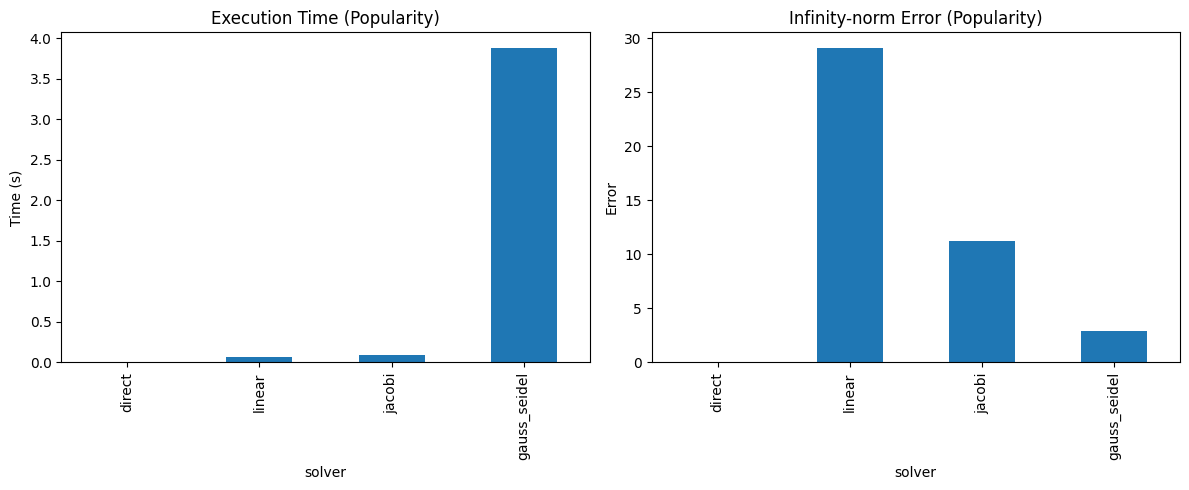

In [143]:
# Bar plots of execution time and infinite-norm error by solver
perf_pop = perf_summary[perf_summary["mode"] == "popularity"].set_index("solver")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
perf_pop["time"].plot.bar(ax=axes[0])
axes[0].set_title("Execution Time (Popularity)")
axes[0].set_ylabel("Time (s)")
perf_pop["error_inf"].plot.bar(ax=axes[1])
axes[1].set_title("Infinity-norm Error (Popularity)")
axes[1].set_ylabel("Error")
plt.tight_layout()


 ### Popularity Distributions by Solver ($f_k$)

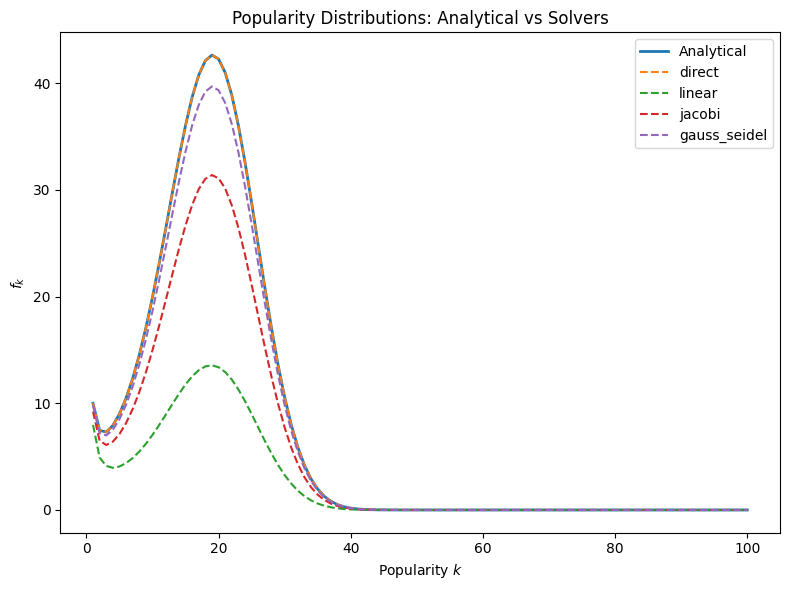

In [144]:
plt.figure(figsize=(8, 6))
N = single_params["N"]
k = np.arange(1, N + 1)

# analytical distribution (raw, unnormalized)
f = popularity(**single_params)
plt.plot(k, f, label="Analytical", linewidth=2)

# solver distributions (raw, unnormalized)
for solver in solver_list:
    sol_vec = perf_solutions.loc[perf_solutions["solver"] == solver, "solution"].values[
        0
    ]
    plt.plot(k, sol_vec, "--", label=solver)

plt.xlabel("Popularity $k$")
plt.ylabel("$f_k$")
plt.title("Popularity Distributions: Analytical vs Solvers")
plt.legend()
plt.tight_layout()


 ### Total Traits by Solver with Analytical Reference

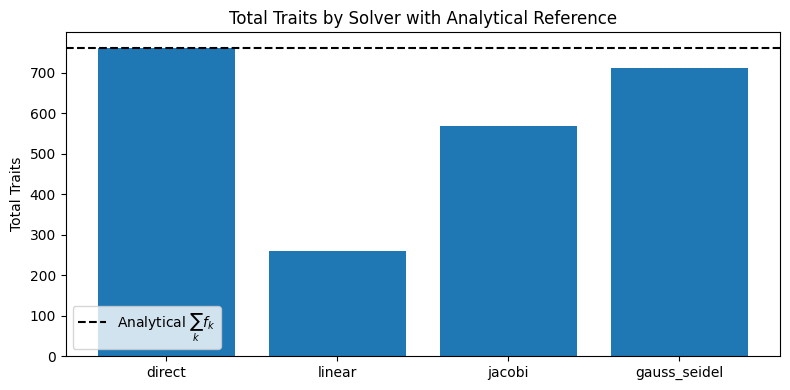

In [145]:
plt.figure(figsize=(8, 4))
labels = perf_solutions["solver"]
values = perf_solutions["total_traits"]
bars = plt.bar(labels, values)

# compute the analytical total traits
analytical_total = np.sum(popularity(**single_params))

# draw a horizontal dashed line at the analytical value
plt.axhline(
    analytical_total,
    color="k",
    linestyle="--",
    linewidth=1.5,
    label=r"Analytical $\sum_k f_k$",
)

plt.ylabel("Total Traits")
plt.title("Total Traits by Solver with Analytical Reference")
plt.legend()
plt.tight_layout()



 ### Solver Summary Metrics

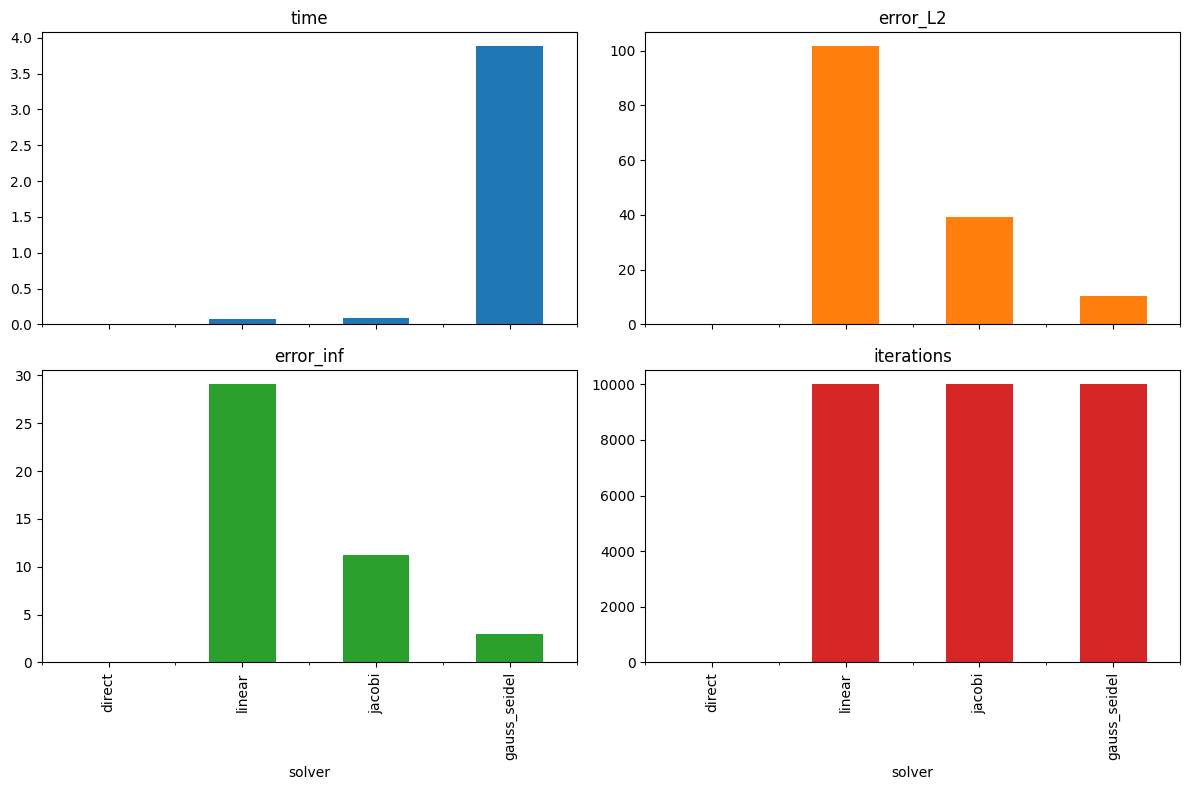

In [146]:
# Summary of time, errors, and iterations per solver
summary = perf_summary.set_index("solver")[
    ["time", "error_L2", "error_inf", "iterations"]
]
summary.plot(kind="bar", subplots=True, layout=(2, 2), figsize=(12, 8), legend=False)
plt.tight_layout()


 ## Convergence Profiles: Iterations vs Tolerance

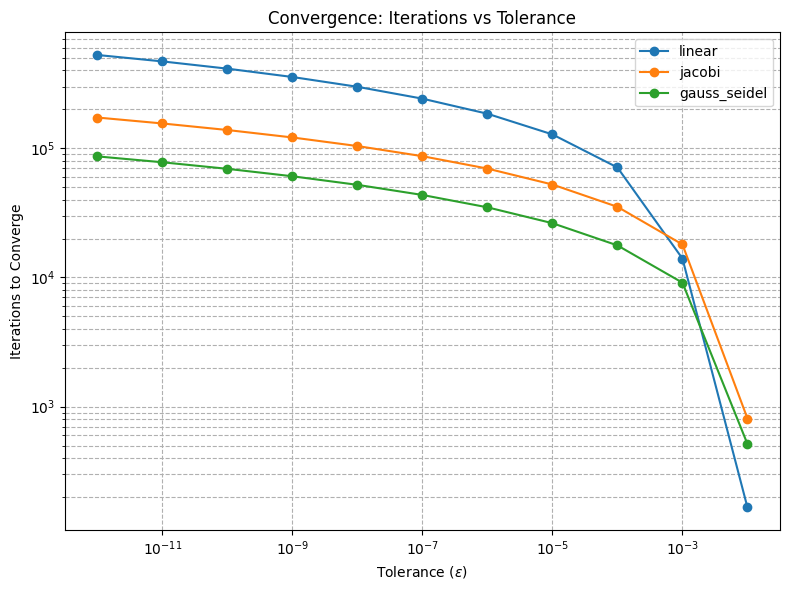

In [147]:
tol_values = np.logspace(-2, -12, 11)
solvers = ["linear", "jacobi", "gauss_seidel"]
results_conv = {solver: [] for solver in solvers}

for tol in tol_values:
    for solver in solvers:
        sol, residuals = solve_model(
            **single_params,
            mode="popularity",
            solver=solver,
            tol=tol,
            trace=True,
            max_iter=0,
        )
        iterations = len(residuals)
        results_conv[solver].append(iterations)

plt.figure(figsize=(8, 6))
for solver in solvers:
    plt.loglog(tol_values, results_conv[solver], marker="o", label=solver)
plt.xlabel(r"Tolerance ($\epsilon$)")
plt.ylabel("Iterations to Converge")
plt.title("Convergence: Iterations vs Tolerance")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()


 ## Residual Decay over Iterations

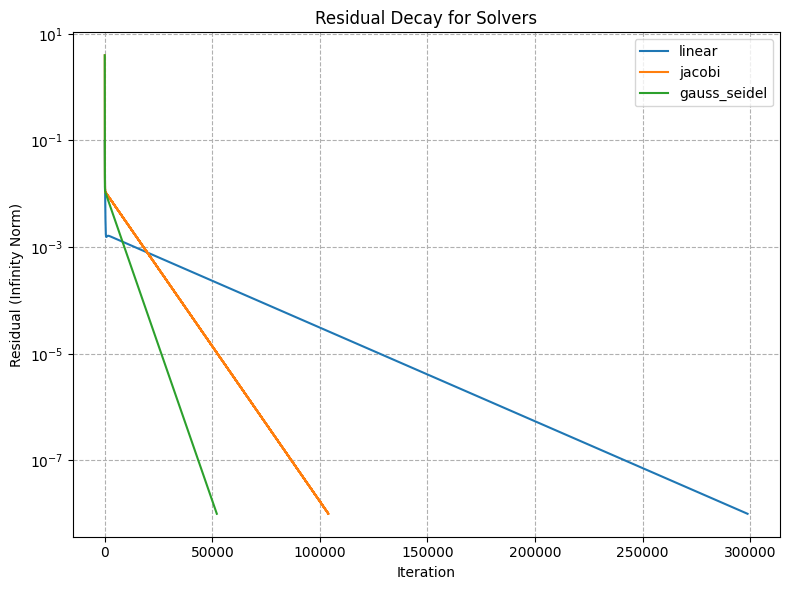

In [148]:
plt.figure(figsize=(8, 6))
for solver in solvers:
    sol, residuals = solve_model(
        **single_params,
        mode="popularity",
        solver=solver,
        tol=1e-8,
        max_iter=0,
        trace=True,
    )
    plt.semilogy(residuals, label=solver)
plt.xlabel("Iteration")
plt.ylabel("Residual (Infinity Norm)")
plt.title("Residual Decay for Solvers")
plt.legend()
plt.grid(True, which="both", linestyle="--")
plt.tight_layout()


 ## 3. Exploration of parameter space over (M, $p_s$)

 ## Analytical Heatmaps over (M, $p_s$)



 Heatmaps of analytical metrics:

 1) $\log(\sum_k f_k)$

 2) Shannon entropy

 3) Simpson index

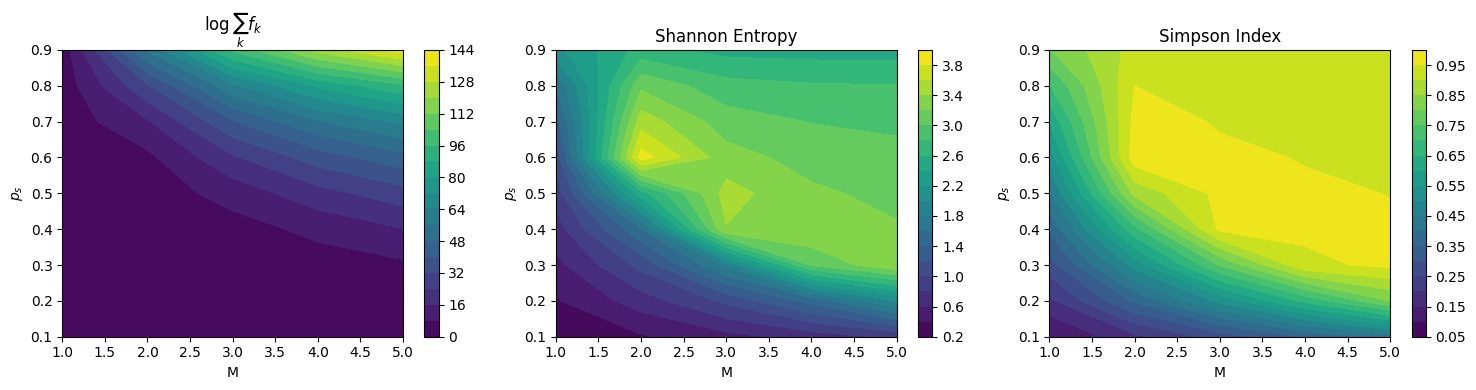

In [149]:
# Define grid
Ms = np.arange(1, 6)
ps = np.linspace(0.1, 0.9, 9)
N_val = baseline_params["N"][0]
p_d_val = baseline_params["p_d"][0]

# Preallocate arrays
log_tot = np.zeros((len(Ms), len(ps)))
entropy = np.zeros_like(log_tot)
simpson = np.zeros_like(log_tot)

for i, M_val in enumerate(Ms):
    for j, p_s_val in enumerate(ps):
        f = popularity(N=N_val, M=M_val, p_d=p_d_val, p_s=p_s_val)
        log_tot[i, j] = np.log(np.sum(f))
        entropy[i, j] = shannon_entropy(f)
        simpson[i, j] = simpson_index(f)

# Plot heatmaps
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
titles = [r"$\log\sum_k f_k$", "Shannon Entropy", "Simpson Index"]
data_list = [log_tot, entropy, simpson]
for ax, data, title in zip(axs, data_list, titles):
    X, Y = np.meshgrid(Ms, ps)
    Z = data.T
    cf = ax.contourf(X, Y, Z, levels=20, cmap="viridis")
    ax.set_xlabel("M")
    ax.set_ylabel(r"$p_s$")
    ax.set_title(title)
    fig.colorbar(cf, ax=ax)
fig.tight_layout()


 ## Solver Matrix Metrics over (M, $p_s$)



 Heatmaps of:

 - Condition number of $I - P^T$

 - Spectral radius of $P^T$

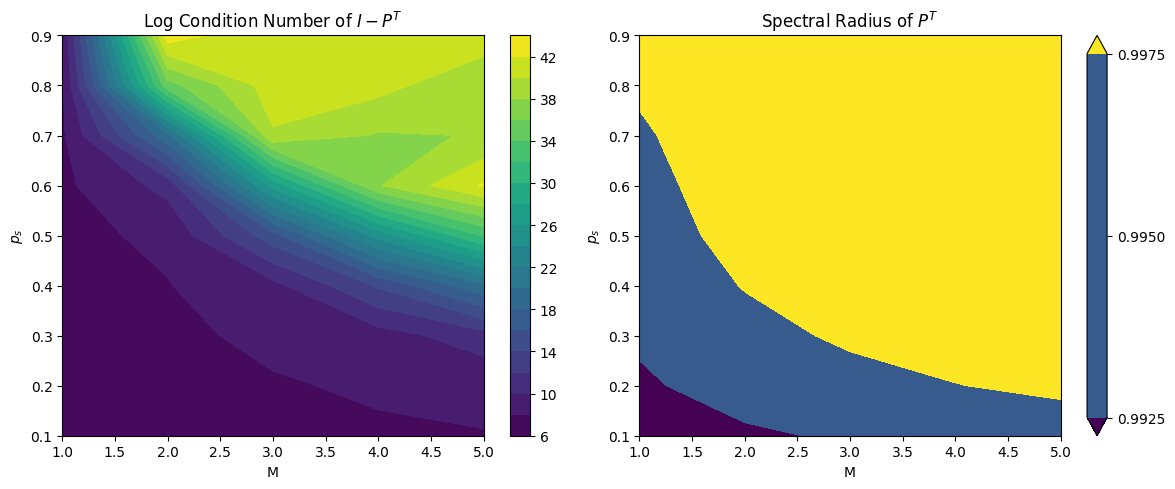

In [152]:
# Allocate arrays
cond_num = np.zeros((len(Ms), len(ps)))
spec_rad = np.zeros_like(cond_num)
# Compute metrics
for i, M_val in enumerate(Ms):
    for j, p_s_val in enumerate(ps):
        # Build transition matrix P
        P, b = get_transition_matrix(N_val, M_val, p_d_val, p_s_val)
        # Compute condition number and spectral radius
        cond_num[i, j] = np.log(np.linalg.cond(np.eye(N_val) - P.T, 2))
        spec_rad[i, j] = np.max(np.abs(np.linalg.eigvals(P.T)))

# Plot contour heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
X, Y = np.meshgrid(Ms, ps)

cf0 = axes[0].contourf(X, Y, cond_num.T, levels=20, cmap="viridis")
axes[0].set_xlabel("M")
axes[0].set_ylabel(r"$p_s$")
axes[0].set_title("Log Condition Number of $I - P^T$")
fig.colorbar(cf0, ax=axes[0])

cf1 = axes[1].contourf(
    X, Y, spec_rad.T, levels=3, vmin=Z.min(), vmax=Z.max(), extend="both"
)
axes[1].set_xlabel("M")
axes[1].set_ylabel(r"$p_s$")
axes[1].set_title("Spectral Radius of $P^T$")
fig.colorbar(cf1, ax=axes[1])

fig.tight_layout()


 ## Solver Metrics Heatmaps over (M, $p_s$)



 Heatmaps for each solver showing:

 - Iterations to converge

 - Execution time

 - Last residual norm

 - Estimated spectral radius from residuals

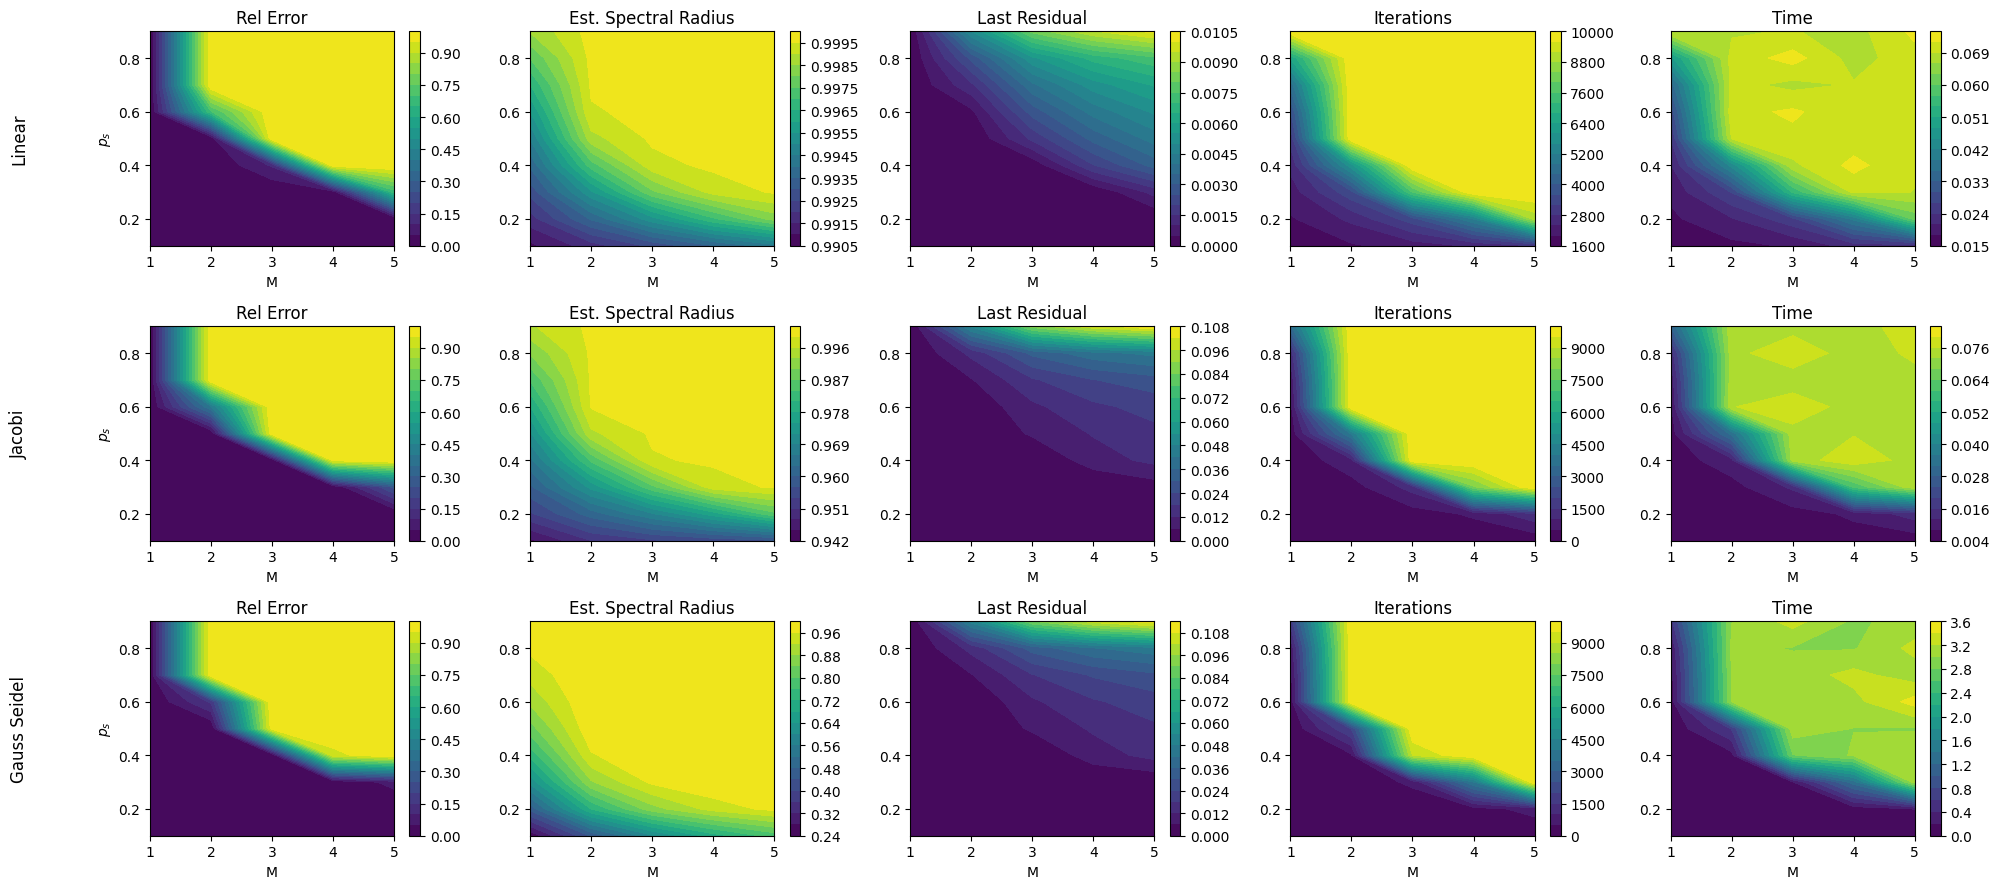

In [151]:
solvers = ["linear", "jacobi", "gauss_seidel"]
metrics = ["rel_error", "spec_rad", "last_residual", "iterations", "time"]
# Initialize data structures
data = {
    solver: {m: np.zeros((len(Ms), len(ps))) for m in metrics} for solver in solvers
}

for i, M_val in enumerate(Ms):
    for j, p_s_val in enumerate(ps):
        # Build transition matrix P
        P, b = get_transition_matrix(N_val, M_val, p_d_val, p_s_val)
        # Matrix metrics
        for solver in solvers:
            # Solve with trace to get residuals
            t0 = time.time()
            sol, residuals = solve_model(
                N_val,
                M_val,
                p_d_val,
                p_s_val,
                mode="popularity",
                solver=solver,
                trace=True,
            )
            data[solver]["time"][i, j] = time.time() - t0
            f = popularity(N_val, M_val, p_d_val, p_s_val)
            data[solver]["rel_error"][i, j] = np.linalg.norm(sol - f) / np.linalg.norm(
                f
            )
            data[solver]["iterations"][i, j] = len(residuals)
            data[solver]["last_residual"][i, j] = residuals[-1] if residuals else np.nan
            if len(residuals) > 1:
                ratios = np.array(residuals[1:]) / np.array(residuals[:-1])
                est_rho = np.mean(ratios)
            else:
                est_rho = np.nan
            data[solver]["spec_rad"][i, j] = est_rho

# Plot solver heatmaps
fig, axes = plt.subplots(
    len(solvers), len(metrics), figsize=(4 * len(metrics), 3 * len(solvers))
)
for si, solver in enumerate(solvers):
    for mi, metric in enumerate(metrics):
        ax = axes[si, mi]
        X, Y = np.meshgrid(Ms, ps)
        Z = data[solver][metric].T
        cf = ax.contourf(X, Y, Z, levels=20, cmap="viridis")
        ax.set_xlabel("M")
        if mi == 0:
            ax.set_ylabel(r"$p_s$")
        if metric == "spec_rad":
            display_title = "Est. Spectral Radius"
        else:
            display_title = metric.replace("_", " ").title()
        ax.set_title(display_title)
        fig.colorbar(cf, ax=ax)

    # Add a row title for the solver
    axes[si, 0].text(
        -0.5,
        0.5,
        solver.replace("_", " ").title(),
        va="center",
        ha="right",
        rotation=90,
        fontsize=12,
        transform=axes[si, 0].transAxes,
    )

fig.tight_layout()
